In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

import sys
import os
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import healpy as hp
import pymaster as nmt
import pyccl as ccl

from env_config import DATA_PATH
from utils import *
from data import *
from cosmology import *

In [3]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
sns.set(style='whitegrid')
pd.set_option('mode.chained_assignment', None)

# Get data

In [4]:
nside = 512
cmb_map, cmb_mask = get_cmb_map(nside=nside)
nvss_map, nvss_mask = get_nvss_map(nside=nside)

/Users/snakoneczny/tools/anaconda3/envs/py37/lib/python3.7/site-packages/healpy/fitsfunc.py:369: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "
/Users/snakoneczny/tools/anaconda3/envs/py37/lib/python3.7/site-packages/healpy/fitsfunc.py:391: UserWarning: NSIDE = 2048
  warnings.warn("NSIDE = {0:d}".format(nside))
/Users/snakoneczny/tools/anaconda3/envs/py37/lib/python3.7/site-packages/healpy/fitsfunc.py:400: UserWarning: ORDERING = NESTED in fits file
  warnings.warn("ORDERING = {0:s} in fits file".format(ordering))
/Users/snakoneczny/tools/anaconda3/envs/py37/lib/python3.7/site-packages/healpy/fitsfunc.py:426: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("

/Users/snakoneczny/tools/anaconda3/envs/py37/lib/python3.7/site-packages/healpy/projaxes.py:211: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
  **kwds
/Users/snakoneczny/tools/anaconda3/envs/py37/lib/python3.7/site-packages/healpy/projaxes.py:543: UserWarning: 0.0 180.0 -180.0 180.0
  pmin / dtor, pmax / dtor, mmin / dtor, mmax / dtor
/Users/snakoneczny/tools/anaconda3/envs/py37/lib/python3.7/site-packages/healpy/projaxes.py:658: UserWarning: The interval between parallels is 30 deg -0.00'.
  vdeg, varcmin
/Users/snakoneczny/tools/anaconda3/envs/py37/lib/python3.7/site-packages/healpy/projaxes.py:666: UserWarning: The interval between meridians is 30 deg -0.00'.
  vdeg, varcmin


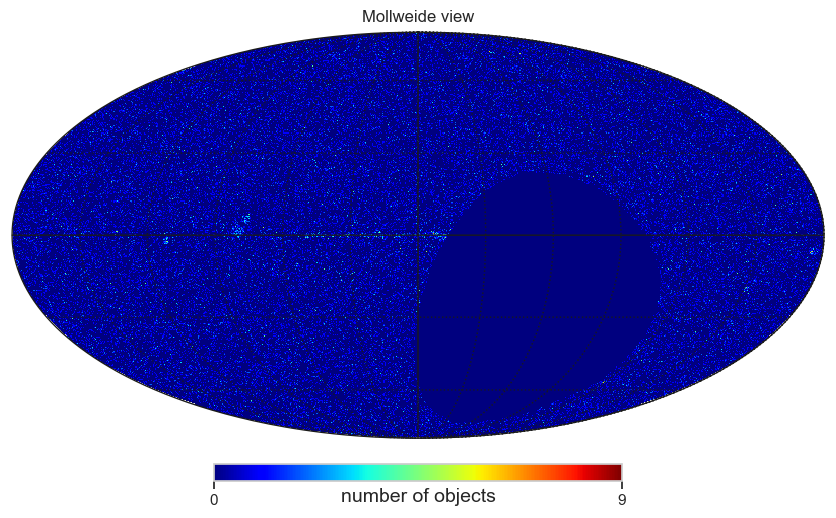

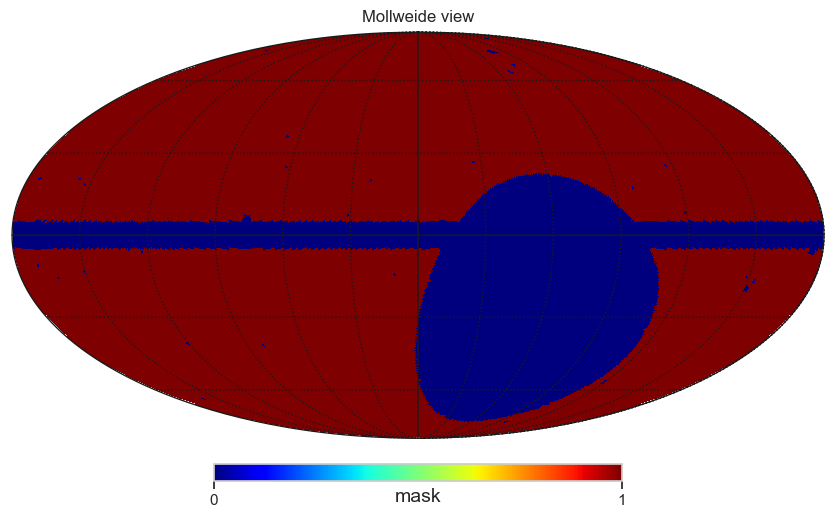

In [5]:
hp.mollview(nvss_map, cmap='jet', unit='number of objects')
hp.graticule()

hp.mollview(nvss_mask, cmap='jet', unit='mask')
hp.graticule()

# Inference
Paper results:
* z: 0-6
* b: 2.18 +/- 0.08; X^2 min 3.02
* b_Halofit: 2.04 +/- 0.08; X^2 min 0.064

In [11]:
# NVSS auto correlation
mask_aposize = 1.0
ells_per_bandpower = 16
gg_coupled, gg_decoupled, gg_workspace, binning, nvss_shot_noise, nvss_field = get_auto_correlation(nvss_map, nvss_mask, nside, ells_per_bandpower=ells_per_bandpower, normalize_map=True, with_shot_noise=True, mask_aposize=mask_aposize)

Shot noise: 1.8111368792204264e-05


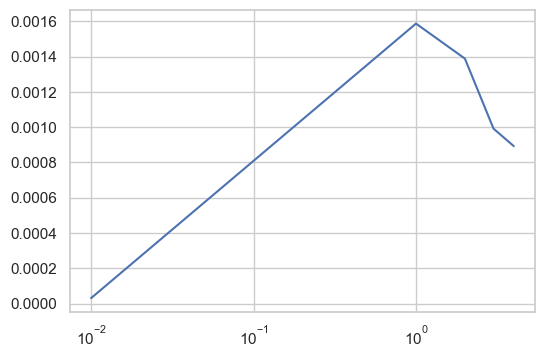

In [12]:
# NVSS redshift distribution
z_arr, n_arr = get_nvss_redshift_distribution(nvss_map, nvss_mask, nside)
plt.plot(z_arr, n_arr)
plt.xscale('log')

In [13]:
# Theoretical matter auto correlation with bias
bias = 2.18  # 2.18
bias_arr = (bias ** 2) * np.ones(len(z_arr))  # Galaxy bias constant with scale and z
l_arr = np.arange(2, 3 * nside + 2)
gg_theory = get_theory_clustering_correlation(l_arr, z_arr, n_arr, bias_arr)

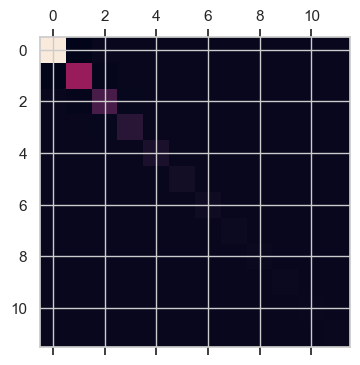

In [14]:
n_bands = binning.get_n_bands()
covariance_gg_gg = get_covariance_gg_gg(nvss_field, gg_theory, gg_workspace, n_bands)
plt.matshow(covariance_gg_gg[:12, :12])

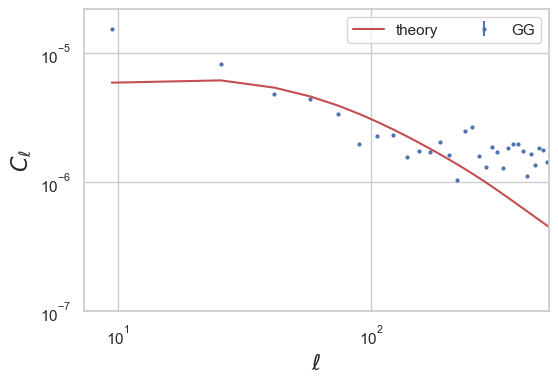

In [15]:
# Sparse z bins, custom discrete distribution
gg_theory_binned = binning.bin_cell(gg_theory)
plot_correlation(binning, gg_decoupled, model_correlation=gg_theory_binned, covariance_matrix=covariance_gg_gg, x_max=500, y_min=10e-8, x_scale='log', y_scale='log')